## Text-Mining-Project-US-EU-Diplomatic-Communications-2013-2015

## Dictionary & corpus based

**Introduction: Corpus-based topic modeling with LDA**


**Main Assumption**


2. Data & preprocessing
3. Dictionary and corpus construction
4. LDA model and topic selection
5. Topic interpretation
6. EU vs non-EU comparison

## **1. Import Libraries**

**Code test on Python(.venv)3.12.4**

In [1]:
## Import libraries
#! python -m spacy download en_core_web_sm
#! pip install sapcy

# Core data and NLP
from pathlib import Path
import os
import pandas as pd
import numpy as np
import spacy

# Topic modeling
import gensim
import gensim.corpora as corpora
from gensim.models import LdaModel, CoherenceModel

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim.corpora import Dictionary


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/runpy.py", line 198, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/runpy.py", line 88, in _run_code
    exec(code, run_globals)
  File "/Users/ninalin/Desktop/.venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/ninalin/Desktop/.venv/lib/python3.12/site-packages/traitlets/config/appl


## **2. Import Data**
  
**Reuse the same preprocessed text chunks as in the BERTopic analysis for comparability.**
   

In [2]:
## Check work_dir

os.listdir(".")

CWD = os.getcwd()
PROJECT_ROOT = os.path.dirname(CWD)
CLEAN_DIR = os.path.join(PROJECT_ROOT, "clean")

print("CWD:", CWD)
print("PROJECT_ROOT:", PROJECT_ROOT)
print("CLEAN_DIR:", CLEAN_DIR)
PROJECT_ROOT = Path.cwd().parent

for p in PROJECT_ROOT.rglob("*.parquet"):
    print(p)

CWD: /Users/ninalin/Desktop/dsba/winter semester 25/text mining/project/Text-Mining-Project-US-EU-Diplomatic-Communications-2013-2015-/notebook
PROJECT_ROOT: /Users/ninalin/Desktop/dsba/winter semester 25/text mining/project/Text-Mining-Project-US-EU-Diplomatic-Communications-2013-2015-
CLEAN_DIR: /Users/ninalin/Desktop/dsba/winter semester 25/text mining/project/Text-Mining-Project-US-EU-Diplomatic-Communications-2013-2015-/clean
/Users/ninalin/Desktop/dsba/winter semester 25/text mining/project/Text-Mining-Project-US-EU-Diplomatic-Communications-2013-2015-/dataset /clean/corpus_chunks_2013_2015.parquet


In [3]:
## Import Data

PROJECT_ROOT = Path.cwd().parent

df = pd.read_parquet(
    PROJECT_ROOT / "dataset " / "clean" / "corpus_chunks_2013_2015.parquet"
)
df.shape, df.head()

((26785, 7),
    year      country  is_eu            section      source_file  \
 0  2013  Afghanistan  False  EXECUTIVE SUMMARY  Afghanistan.txt   
 1  2013  Afghanistan  False         Section 1.  Afghanistan.txt   
 2  2013  Afghanistan  False         Section 1.  Afghanistan.txt   
 3  2013  Afghanistan  False         Section 1.  Afghanistan.txt   
 4  2013  Afghanistan  False         Section 1.  Afghanistan.txt   
 
                                 chunk_id  \
 0  Afghanistan.txt::EXECUTIVE SUMMARY::0   
 1         Afghanistan.txt::Section 1.::0   
 2         Afghanistan.txt::Section 1.::1   
 3         Afghanistan.txt::Section 1.::2   
 4         Afghanistan.txt::Section 1.::3   
 
                                                 text  
 0  Share Afghanistan is an Islamic republic with ...  
 1  Respect for the Integrity of the Person, Inclu...  
 2  judges, prosecutors, and clerical staff. In Ju...  
 3  were reports that insurgent groups were respon...  
 4  with fists and electr

In [4]:
# Preprocess 
df = df.copy()

df["year"] = df["year"].astype(int)
assert df["text"].str.strip().eq("").sum() == 0

## **3. Corpus-base**

>All documents processed using the **spaCy NLP pipeline**.
>
>The preprocessing steps included **tokenization, lemmatization, lowercasing**, and the **removal of stopwords** and **non-alphabetic tokens**.
>
>Only tokens with a minimum length of three characters were retained.
>
>As a result, each document was represented as a list of cleaned and lemmatized tokens.

In [5]:
## Load spacy

nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

## Process function
def preprocess(text):
    doc = nlp(text)
    tokens = [
        token.lemma_.lower()
        for token in doc
        if token.is_alpha
        and not token.is_stop
        and len(token) > 2
    ]
    return tokens

In [6]:
## Apply data and Inspection

df["tokens"] = df["text"].apply(preprocess)
print(df["tokens"].head())

0    [share, afghanistan, islamic, republic, strong...
1    [respect, integrity, person, include, freedom,...
2    [judge, prosecutor, clerical, staff, june, tal...
3    [report, insurgent, group, responsible, disapp...
4    [fist, electric, cable, kicking, choke, electr...
Name: tokens, dtype: object


In [7]:
## Dictionary

dictionary = Dictionary(df["tokens"])
print(len(dictionary))

## Remove extremely rare word,
dictionary.filter_extremes(
    no_below=10,   
    no_above=0.5  
)
print(len(dictionary))

42107
9490


>A dictionary was constructed from the preprocessed tokens.
>
>Extremely rare and overly frequent terms were removed by retaining only tokens that appeared in at least 10 documents and in no more than 50% of the corpus.
>
>After filtering, the dictionary size was reduced from 42107 to 9490 unique tokens."

## **4. Bag of word corpus**

In [8]:
## BoW
corpus = [dictionary.doc2bow(tokens) for tokens in df["tokens"]]
corpus[0][:10]

[(0, 8),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1)]

Converted document into a bag-of-words representation based on the filtered dictionary, where each document is represented as a list of (token_id, frequency) pairs.

In [9]:
## Saved dictionary and corpus

dictionary.save("lda_dictionary.dict")
gensim.corpora.MmCorpus.serialize("lda_corpus.mm", corpus)
   

## **5. Coherence Sweep**

In [10]:
## Coherence function

def compute_coherence_values(dictionary, corpus, texts, k_values):
    coherence_scores = []
    models = {}

    for k in k_values:
        print(f"Training LDA with K={k}")
        lda = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=k,
            random_state=42,
            passes=10,
            alpha="auto",
            eta="auto"
        )
        models[k] = lda

        coherence = CoherenceModel(
            model=lda,
            texts=texts,
            dictionary=dictionary,
            coherence="c_v"
        ).get_coherence()

        coherence_scores.append(coherence)

    return models, coherence_scores
   

In [11]:
## K range
k_values = list(range(5, 21, 2))  # 5,7,9,...,19

lda_models, coherence_scores = compute_coherence_values(
    dictionary=dictionary,
    corpus=corpus,
    texts=df["tokens"],
    k_values=k_values
)

Training LDA with K=5
Training LDA with K=7
Training LDA with K=9
Training LDA with K=11
Training LDA with K=13
Training LDA with K=15
Training LDA with K=17
Training LDA with K=19


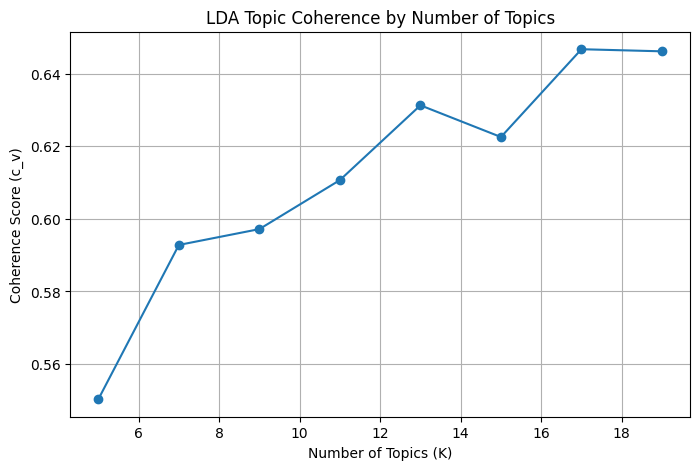

In [12]:
## K

best_k = k_values[coherence_scores.index(max(coherence_scores))]
best_k

plt.figure(figsize=(8, 5))
plt.plot(k_values, coherence_scores, marker="o")
plt.xlabel("Number of Topics (K)")
plt.ylabel("Coherence Score (c_v)")
plt.title("LDA Topic Coherence by Number of Topics")
plt.grid(True)
plt.show()

In [13]:
## LDA model

final_k = best_k 
lda_model = lda_models[final_k]

for topic_id, topic_words in lda_model.print_topics(num_words=10):
    print(f"Topic {topic_id}: {topic_words}")

Topic 0: 0.040*"worker" + 0.029*"work" + 0.024*"labor" + 0.023*"hour" + 0.022*"wage" + 0.017*"sector" + 0.016*"safety" + 0.016*"health" + 0.016*"employer" + 0.016*"pay"
Topic 1: 0.036*"police" + 0.025*"force" + 0.019*"security" + 0.012*"arrest" + 0.009*"torture" + 0.009*"military" + 0.009*"member" + 0.009*"kill" + 0.008*"group" + 0.008*"officer"
Topic 2: 0.039*"refugee" + 0.029*"country" + 0.025*"asylum" + 0.018*"person" + 0.017*"protection" + 0.014*"seeker" + 0.013*"unhcr" + 0.011*"travel" + 0.010*"status" + 0.010*"movement"
Topic 3: 0.044*"public" + 0.038*"information" + 0.022*"official" + 0.021*"access" + 0.020*"require" + 0.015*"financial" + 0.013*"disclosure" + 0.012*"request" + 0.009*"state" + 0.008*"asset"
Topic 4: 0.048*"election" + 0.038*"political" + 0.036*"party" + 0.016*"member" + 0.014*"woman" + 0.013*"president" + 0.013*"participation" + 0.012*"national" + 0.012*"opposition" + 0.011*"parliament"
Topic 5: 0.034*"freedom" + 0.019*"medium" + 0.016*"journalist" + 0.014*"inter

## **6. Automatic Topic Generation**

In [14]:
## Domain Topic

def get_dominant_topic(lda_model, bow, min_prob=0.0):
    topics = lda_model.get_document_topics(bow, minimum_probability=min_prob)
    if not topics:
        return -1
    return max(topics, key=lambda x: x[1])[0]

In [15]:
## Save topic to df

df["topic"] = [
    get_dominant_topic(lda_model, bow)
    for bow in corpus]

In [16]:
## Topic Index Range Validation
assert df["topic"].max() < lda_model.num_topics
assert df["topic"].min() >= -1

In [17]:
## Topic label

def auto_topic_label(lda_model, topic_id, topn=5):
    words = [w for w, _ in lda_model.show_topic(topic_id, topn)]
    return " / ".join(words[:2])

topic_labels_auto = {
    t: auto_topic_label(lda_model, t)
    for t in range(lda_model.num_topics)
}

df["topic_label_auto"] = (
    df["topic"]
    .map(topic_labels_auto)
    .fillna("outlier")
)

print(df[["topic", "topic_label_auto"]].drop_duplicates().sort_values("topic"))

    topic         topic_label_auto
75      0            worker / work
1       1           police / force
33      2        refugee / country
46      3     public / information
36      4     election / political
27      5         freedom / medium
59      6            woman / child
0       7           human / rights
18      8        corruption / case
12      9             court / case
16     10         violence / woman
68     11      disability / person
73     12            labor / child
6      13        prison / prisoner
72     14           union / worker
57     15              child / age
70     16  discrimination / person


### **6.1 Model Quality Evaluation**

In [18]:
## Topic Diversity

def topic_diversity(topics, top_n=10):
    words = [w for topic in topics for w in topic[:top_n]]
    return len(set(words)) / len(words)

topics = [
    [word for word, _ in lda_model.show_topic(topic_id, topn=10)]
    for topic_id in range(lda_model.num_topics)
]
td_score = topic_diversity(topics, top_n=10)
print(td_score)

0.7352941176470589


In [19]:
## Topic distribution

topic_distributions = [
    lda_model.get_document_topics(bow, minimum_probability=0)
    for bow in corpus
]

In [20]:
print(df)


       year      country  is_eu            section      source_file  \
0      2013  Afghanistan  False  EXECUTIVE SUMMARY  Afghanistan.txt   
1      2013  Afghanistan  False         Section 1.  Afghanistan.txt   
2      2013  Afghanistan  False         Section 1.  Afghanistan.txt   
3      2013  Afghanistan  False         Section 1.  Afghanistan.txt   
4      2013  Afghanistan  False         Section 1.  Afghanistan.txt   
...     ...          ...    ...                ...              ...   
26780  2015     Zimbabwe  False         Section 7.     Zimbabwe.txt   
26781  2015     Zimbabwe  False         Section 7.     Zimbabwe.txt   
26782  2015     Zimbabwe  False         Section 7.     Zimbabwe.txt   
26783  2015     Zimbabwe  False         Section 7.     Zimbabwe.txt   
26784  2015     Zimbabwe  False         Section 7.     Zimbabwe.txt   

                                    chunk_id  \
0      Afghanistan.txt::EXECUTIVE SUMMARY::0   
1             Afghanistan.txt::Section 1.::0   
2  

### **6.2 Concate to full data**

## **7. Topic-Based Analysis**

In [35]:
# Pre-compute reusable variables

# ---- 1. Topic probability columns ----
topic_cols = [
    c for c in df.columns
    if c.startswith("topic_") and c.split("_")[1].isdigit()
]
topic_ids = [
    int(c.replace("topic_", ""))
    for c in topic_cols
]

# topic id → topic name
topic_id_to_name = {
    t: auto_topic_label(lda_model, t)
    for t in topic_ids
}

# ---- 2. EU vs non-EU overall means (baseline comparison) ----
# 正確的 EU vs Non-EU comparison（dominant topic）

eu_topic_dist = (
    df[df["is_eu"]]["topic"]
    .value_counts(normalize=True)
)

noneu_topic_dist = (
    df[~df["is_eu"]]["topic"]
    .value_counts(normalize=True)
)

comparison_df = (
    pd.DataFrame({
        "EU": eu_topic_dist,
        "Non_EU": noneu_topic_dist
    })
    .fillna(0)
    .reset_index()
)

comparison_df.columns = ["topic", "EU", "Non_EU"]
comparison_df["diff_eu_minus_non_eu"] = (
    comparison_df["EU"] - comparison_df["Non_EU"]
)

topic_label_map = (
    df[["topic", "topic_label_auto"]]
    .drop_duplicates()
    .set_index("topic")["topic_label_auto"]
)

comparison_df["topic_label_auto"] = (
    comparison_df["topic"].map(topic_label_map)
)


# ---- 3. Overall yearly topic means (no EU split) ----
yearly = (
    df
    .groupby("year")[topic_cols]
    .mean()
    .sort_index()
)


# clean column names: topic id as int
#yearly.columns = topic_ids

# ---- 4. Yearly topic means by EU / non-EU ----
yearly_by_group = (
    df
    .groupby(["is_eu", "year"])[topic_cols]
    .mean()
    .reset_index()
)

eu_yearly = yearly_by_group[yearly_by_group["is_eu"]]
noneu_yearly = yearly_by_group[~yearly_by_group["is_eu"]]


# clean column names
yearly_by_group.columns = (
    ["is_eu", "year"] + topic_ids
)

# optional: split for convenience
eu_yearly = yearly_by_group[
    yearly_by_group["is_eu"]
]

noneu_yearly = yearly_by_group[
    ~yearly_by_group["is_eu"]
]

#### **7.1 Overview of Dominant Topics plot**

In [29]:
# 7.1 Dominant topics overall


topic_counts = (
    df["topic"]
    .value_counts(normalize=True)
    .sort_index()
)

dominant_df = topic_counts.reset_index()
dominant_df.columns = ["topic", "proportion"]


topic_label_map = (
    df[["topic", "topic_label_auto"]]
    .drop_duplicates()
    .set_index("topic")["topic_label_auto"]
)

dominant_df["topic_label_auto"] = dominant_df["topic"].map(topic_label_map)

print(dominant_df.sort_values(
    "proportion", ascending=False
).head(10))


    topic  proportion         topic_label_auto
9       9    0.108270             court / case
1       1    0.096845           police / force
5       5    0.091394         freedom / medium
13     13    0.070637        prison / prisoner
2       2    0.070413        refugee / country
16     16    0.058242  discrimination / person
0       0    0.057868            worker / work
6       6    0.055591            woman / child
10     10    0.051596         violence / woman
12     12    0.049655            labor / child


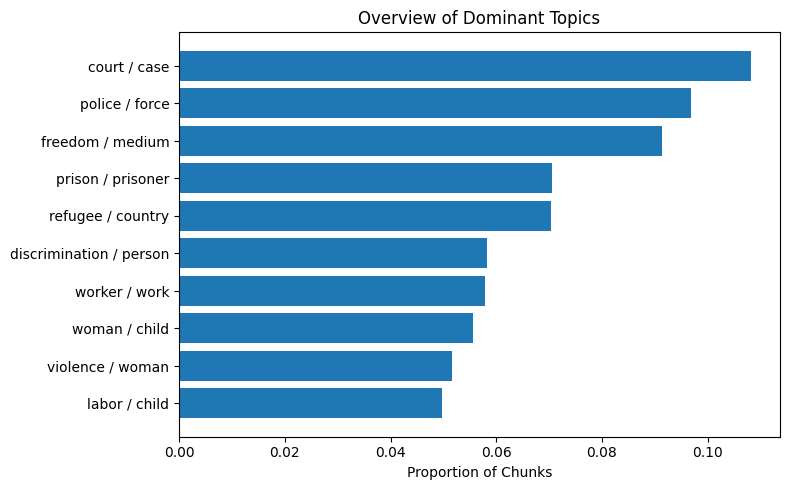

In [23]:
## Over all plot visualization

plot_df = dominant_df.sort_values(
    "proportion", ascending=False
).head(10)

plt.figure(figsize=(8, 5))
plt.barh(
    plot_df["topic_label_auto"][::-1],
    plot_df["proportion"][::-1]
)
plt.xlabel("Proportion of Chunks")
plt.title("Overview of Dominant Topics")
plt.tight_layout()
plt.show()



#### **Analysis**

Figure 7.1 presents an overview of the dominant topics across the entire dataset.


The results shows that topic regarding court and case-related issues, accounting for the largest proportion. Followed by themes with policing and law enforcement. Topics—such as prison conditions, refugee-related concerns, discrimination also appear prominently. 

Overall, the distribution suggests that human rights reporting during the period under study is strongly emphasis.


#### **7.2 EU vs Non-EU Framing Differences**

In [36]:
## EU-focused interpretation

comparison_df = comparison_df.copy()

# 建立 topic → topic_label_auto 的 mapping（來自 df 本身）
topic_label_map = (
    df[["topic", "topic_label_auto"]]
    .drop_duplicates()
    .set_index("topic")["topic_label_auto"]
)


final_72 = (
    comparison_df
    .sort_values("diff_eu_minus_non_eu", ascending=False)
    [["topic", "topic_label_auto", "EU", "Non_EU", "diff_eu_minus_non_eu"]]
    .reset_index(drop=True)
)

print(final_72.head(10))



   topic         topic_label_auto        EU    Non_EU  diff_eu_minus_non_eu
0     16  discrimination / person  0.108089  0.052522              0.055566
1     11      disability / person  0.068190  0.041119              0.027071
2      2        refugee / country  0.091766  0.067962              0.023804
3     13        prison / prisoner  0.084512  0.069044              0.015468
4     10         violence / woman  0.064563  0.050108              0.014455
5      3     public / information  0.032281  0.017854              0.014427
6      0            worker / work  0.067102  0.056809              0.010293
7     15              child / age  0.044976  0.042450              0.002526
8      9             court / case  0.107363  0.108374             -0.001010
9      4     election / political  0.043163  0.048985             -0.005822



#### **Analysis**

Analysis on EU-focused perspective, we present the discour by compare eu to non-eu. EU focus topic around iscrimination, disability, refugees, gender-based violence, and prisoners’ rights.

By contrast, "courts, human rights, and children" appear within EU and non-EU documents, suggesting shared global concerns.



#### **7.3 Temporal Changes in Topics (2013–2015)**

In [37]:
# 7.3 Overall temporal distribution of topics

yearly_topic_dist = (
    df
    .groupby("year")["topic"]
    .value_counts(normalize=True)
    .rename("proportion")
    .reset_index()
)

# 加上 topic label
topic_label_map = (
    df[["topic", "topic_label_auto"]]
    .drop_duplicates()
    .set_index("topic")["topic_label_auto"]
)

yearly_topic_dist["topic_label_auto"] = (
    yearly_topic_dist["topic"].map(topic_label_map)
)

yearly_topic_dist.head()


,year,topic,proportion,topic_label_auto
0,2013,9,0.109813,court / case
1,2013,1,0.096301,police / force
2,2013,5,0.089202,freedom / medium
3,2013,13,0.075003,prison / prisoner
4,2013,2,0.068018,refugee / country


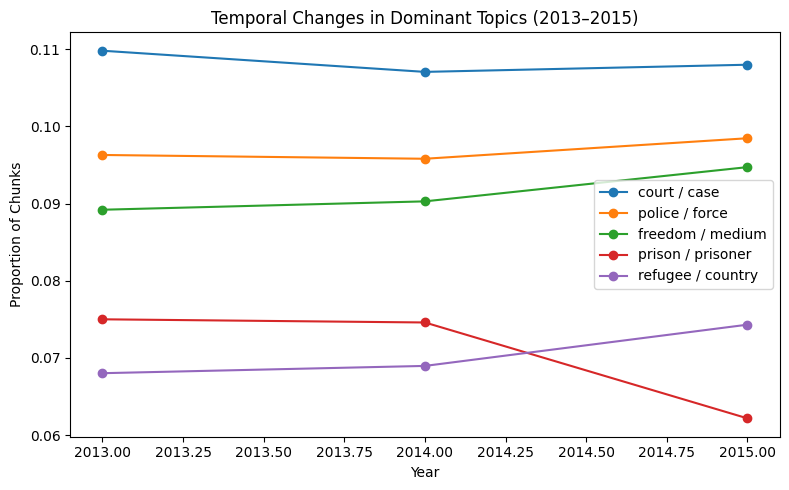

In [38]:
# Top five topic
top_topics = (
    df["topic"]
    .value_counts()
    .head(5)
    .index
)

top_topics

plt.figure(figsize=(8, 5))

for t in top_topics:
    subset = yearly_topic_dist[yearly_topic_dist["topic"] == t]
    plt.plot(
        subset["year"],
        subset["proportion"],
        marker="o",
        label=topic_label_map[t]
    )

plt.xlabel("Year")
plt.ylabel("Proportion of Chunks")
plt.title("Temporal Changes in Dominant Topics (2013–2015)")
plt.legend()
plt.tight_layout()
plt.show()

#### **Analysis**

Figure 7.3a illustrates the evolution of dominant topics between 2013 and 2015. 

Court- and case-related issues as well as policing and law enforcement—remain consistently prominent throughout the period. In contrast, freedom of expression and media, display a gradual upward trend over time.



In [39]:
# Proportion distribution

table_73 = (
    yearly_topic_dist[
        yearly_topic_dist["topic"].isin(top_topics)
    ]
    .pivot_table(
        index="topic_label_auto",
        columns="year",
        values="proportion"
    )
)

table_73


year,2013,2014,2015
topic_label_auto,,,
court / case,0.109813,0.107069,0.107998
freedom / medium,0.089202,0.090289,0.094725
police / force,0.096301,0.095810,0.098469
prison / prisoner,0.075003,0.074591,0.062167
refugee / country,0.068018,0.068962,0.074305


In [ ]:
# Year x Topic proportion matrix (overall, not EU-split)

yearly_topics = (
    df
    .groupby("year")["topic"]
    .value_counts(normalize=True)
    .rename("proportion")
    .reset_index()
    .pivot(
        index="year",
        columns="topic",
        values="proportion"
    )
    .fillna(0)
)

yearly_topics.head()
topic_label_map = (
    df[["topic", "topic_label_auto"]]
    .drop_duplicates()
    .set_index("topic")["topic_label_auto"]
)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.imshow(yearly_topics.T, aspect="auto")

plt.colorbar(label="Topic Proportion")

plt.yticks(
    range(len(yearly_topics.columns)),
    [topic_label_map[t] for t in yearly_topics.columns]
)

plt.xticks(
    range(len(yearly_topics.index)),
    yearly_topics.index
)

plt.xlabel("Year")
plt.ylabel("Topic")
plt.title("Heatmap of Topic Proportions Over Time")
plt.tight_layout()
plt.show()


#### **Analysis**

Figure 7.3b presents a heatmap visualization of topic proportions across the three-year period. 



#### **7.4 Comparing Temporal Changes: EU vs Non-EU**

In [ ]:
# EU vs Non-EU temporal topic proportions

yearly_group_topic = (
    df
    .groupby(["is_eu", "year"])["topic"]
    .value_counts(normalize=True)
    .rename("proportion")
    .reset_index()
)

topic_label_map = (
    df[["topic", "topic_label_auto"]]
    .drop_duplicates()
    .set_index("topic")["topic_label_auto"]
)

yearly_group_topic["topic_label_auto"] = (
    yearly_group_topic["topic"].map(topic_label_map)
)

yearly_group_topic.head()


In [ ]:
# Top three different topics
top_diff_topics = (
    comparison_df
    .sort_values("diff_eu_minus_non_eu", ascending=False)
    .head(3)["topic"]
)

top_diff_topics


In [ ]:
# Plot visualization

for t in top_diff_topics:
    plt.figure(figsize=(7, 4))

    for group_value, group_label in [(True, "EU"), (False, "Non-EU")]:
        subset = yearly_group_topic[
            (yearly_group_topic["is_eu"] == group_value) &
            (yearly_group_topic["topic"] == t)
        ]
        plt.plot(
            subset["year"],
            subset["proportion"],
            marker="o",
            label=group_label
        )

    plt.xlabel("Year")
    plt.ylabel("Proportion of Chunks")
    plt.title(f"Temporal Change: {topic_label_map[t]}")
    plt.legend()
    plt.tight_layout()
    plt.show()


#### **7.5 Biggest Topic Shifts within the EU (2013 → 2015)**

In [ ]:
# EU-only topic proportions by year

eu_yearly_topic = (
    df[df["is_eu"]]
    .groupby("year")["topic"]
    .value_counts(normalize=True)
    .rename("proportion")
    .reset_index()
)

topic_label_map = (
    df[["topic", "topic_label_auto"]]
    .drop_duplicates()
    .set_index("topic")["topic_label_auto"]
)

eu_yearly_topic["topic_label_auto"] = (
    eu_yearly_topic["topic"].map(topic_label_map)
)

eu_yearly_topic.head()


In [ ]:
# EU topic proportions in 2013 and 2015

eu_2013 = (
    eu_yearly_topic[eu_yearly_topic["year"] == 2013]
    .set_index("topic")["proportion"]
)

eu_2015 = (
    eu_yearly_topic[eu_yearly_topic["year"] == 2015]
    .set_index("topic")["proportion"]
)


topic_shift = (eu_2015 - eu_2013).fillna(0)

shift_df = topic_shift.reset_index()
shift_df.columns = ["topic", "change_2013_to_2015"]

# 加上 label
shift_df["topic_label_auto"] = (
    shift_df["topic"].map(topic_label_map)
)

shift_df.head()


In [ ]:
# top increase
top_increase = (
    shift_df
    .sort_values("change_2013_to_2015", ascending=False)
    .head(10)
)

# to decrease
top_decrease = (
    shift_df
    .sort_values("change_2013_to_2015", ascending=True)
    .head(10)
)

top_increase, top_decrease


In [ ]:
# plot

plot_df = top_increase.copy()

plt.figure(figsize=(8, 5))
plt.barh(
    plot_df["topic_label_auto"][::-1],
    plot_df["change_2013_to_2015"][::-1]
)
plt.axvline(0, linewidth=0.8)
plt.xlabel("Change in Topic Proportion (2015 − 2013)")
plt.title("Biggest Topic Increases within the EU (2013–2015)")
plt.tight_layout()
plt.show()


#### **7.6 Synthesis and Interpretation**

In [ ]:
# 7.7.1 Merge EU-vs-Non-EU differences with EU internal shifts

synthesis_df = (
    comparison_df
    .merge(
        shift_df[["topic", "change_2013_to_2015"]],
        on="topic",
        how="left"
    )
)

synthesis_df.head()

synthesis_df["eu_focused"] = synthesis_df["diff_eu_minus_non_eu"] > 0
synthesis_df["eu_increasing"] = synthesis_df["change_2013_to_2015"] > 0

synthesis_df["core_eu_shift"] = (
    synthesis_df["eu_focused"] & synthesis_df["eu_increasing"]
)

synthesis_df[
    ["topic", "topic_label_auto",
     "diff_eu_minus_non_eu", "change_2013_to_2015",
     "eu_focused", "eu_increasing", "core_eu_shift"]
].head()


#### **Analysis**

By integrating cross-sectional and temporal analyses, this section identifies topics that constitute a core shift in EU human rights discourse. 

Specifically, topics are classified as EU-focused when they appear more frequently in EU reports than in non-EU reports, and as increasing when their prevalence within EU reports rises between 2013 and 2015.

Applying this framework reveals that labor-related issues and refugee-related topics satisfy both conditions. 
These topics not only distinguish EU reports from those of non-EU countries, but also exhibit a clear upward trajectory within the EU over time. 
Together, these patterns suggest a substantive reorientation of EU human rights discourse toward socio-economic rights and migration-related concerns.
